# Import

In [71]:
import sys
import os
import glob
import gc
import datetime

import pandas as pd
import numpy as np
from dotenv import load_dotenv
load_dotenv(verbose=False)
# viz
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from utils.loguri import setup_logger, logging_resource
from utils.now import get_now


In [72]:
# 로그 디렉토리 및 파일 설정
LOG_DIR = os.getenv("PATH_LOG_VIRTUAL")
now = get_now()
setup_logger(LOG_DIR, now)
logging_resource()

2024-12-02 22:12:54.061 | INFO     | utils.loguri:logging_resource:86 - 5.1 | 2984.953 | 24037.179 | 51673.722 | 1031018.425 | 124.383 | 260.908


In [73]:
PATH_DATA = os.getenv("PATH_DATA_VIRTUAL")
PATH_RAW = os.path.join(PATH_DATA, "raw")

# 개요

관망구조 A에 대한 EDA

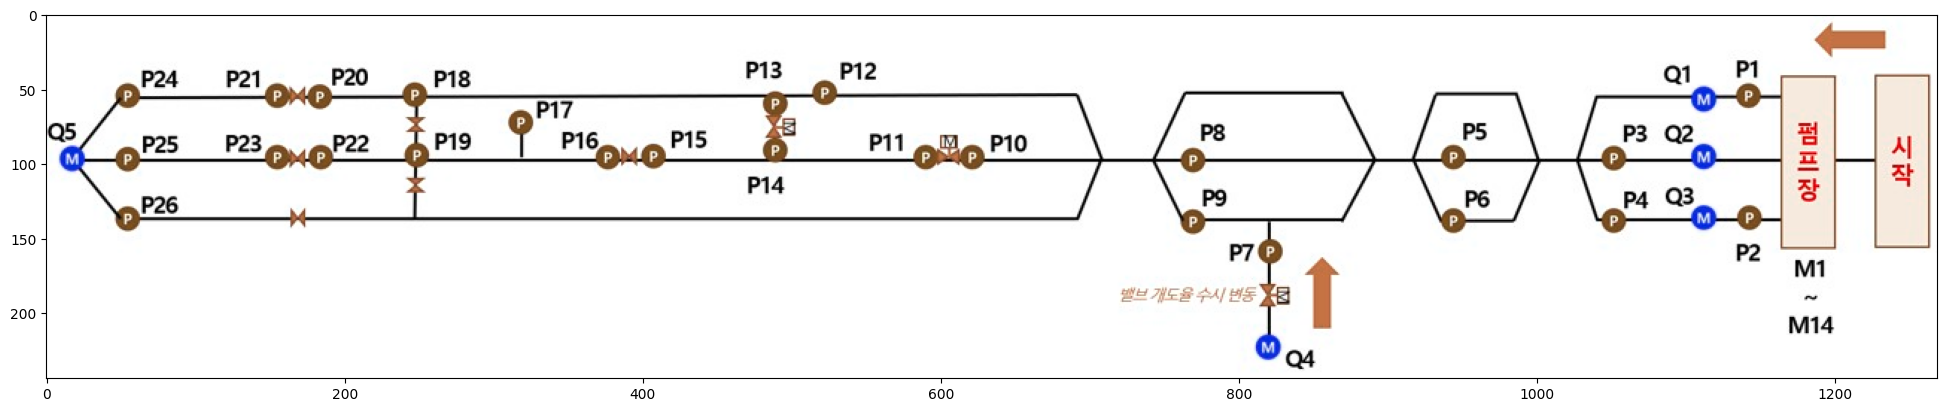

In [74]:
path_image = "meta_관망구조이미지/train/관망구조_A.jpg"
scale = 0.1

path_image = os.path.join(PATH_RAW, path_image)
im = cv2.imread(path_image)
plt.figure(figsize=(im.shape[0]*scale,im.shape[1]*scale))
plt.imshow(im)

"관망구조_A의 경우에는 물이 들어와서 중앙에서 합류하는 특이케이스인 관계로 화살표 방향을 표시하였으며, 화살표 방향이 없는 나머지 관망 B,C,D는 모두 물이 빠져나가는 구조입니다."
즉, 문의주신 관망구조_C의 경우에도 특이케이스가 아니므로 별다른 화살표 방향이 없으며, 모두 물이 빠져나가는 구조입니다.


In [75]:
path_data = "train/TRAIN_A.csv"
path_data = os.path.join(PATH_RAW, path_data)
df = pd.read_csv(path_data)

In [76]:
df.shape

(44101, 73)

In [77]:
df.columns

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P26', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag', 'P11_flag', 'P12_flag', 'P13_flag', 'P14_flag', 'P15_flag',
       'P16_flag', 'P17_flag', 'P18_flag', 'P19_flag', 'P20_flag', 'P21_flag',
       'P22_flag', 'P23_flag', 'P24_flag', 'P25_flag', 'P26_flag'],
      dtype='object')

시간, Q 5개, M 14개, P 26개, P_flag 26개, 어노말리로 이루어짐

# Univariate Analysis

### timestamp

In [78]:
df['timestamp'].head(5)

0    24/05/27 00:00
1    24/05/27 00:01
2    24/05/27 00:02
3    24/05/27 00:03
4    24/05/27 00:04
Name: timestamp, dtype: object

일반적이지 않은 날짜 형태의 string이므로 데이터 처리 필요

In [79]:
df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, "%y/%m/%d %H:%M"))

In [80]:
df.shape, df.set_index("timestamp").resample("1T").mean().shape, df['timestamp'].isna().sum()

/tmp/ipykernel_4796/1318956027.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.shape, df.set_index("timestamp").resample("1T").mean().shape, df['timestamp'].isna().sum()


((44101, 73), (44101, 72), np.int64(0))

1분간격 연속 시간값으로 보입니다.

In [81]:
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2024-05-27 00:00:00'), Timestamp('2024-06-26 15:00:00'))

### anomaly, P_flag

- anomaly: 해당 시점에서의 정상(0), 이상(1) 여부
- P_flag: 해당 시점에서의 압력계의 정상(0), 이상(1) 여부

In [82]:
df["anomaly"].unique()

array([0, 1])

In [83]:
df["anomaly"].isna().sum()

np.int64(0)

In [84]:
df["anomaly"].value_counts()

anomaly
0    44071
1       30
Name: count, dtype: int64

결측 없이 이상치(1) 30개 존재

In [85]:
df

,timestamp,Q1,Q2,Q3,Q4,Q5,M1,M2,M3,M4,...,P17_flag,P18_flag,P19_flag,P20_flag,P21_flag,P22_flag,P23_flag,P24_flag,P25_flag,P26_flag
0,2024-05-27 00:00:00,17880,37151.001,24834.001,6321,85828,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2024-05-27 00:01:00,17970,37069.001,25016.001,6367,85212,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2024-05-27 00:02:00,17280,37345.000,24462.000,6431,85655,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2024-05-27 00:03:00,17280,37345.000,24462.000,6431,85619,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2024-05-27 00:04:00,17920,37075.000,24896.001,6206,85619,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44096,2024-06-26 14:56:00,17610,32767.000,41071.001,6364,97783,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44097,2024-06-26 14:57:00,17490,32866.001,40488.000,6469,96785,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44098,2024-06-26 14:58:00,17490,32866.001,40488.000,6469,97707,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
44099,2024-06-26 14:59:00,18300,32646.001,41702.002,6616,97707,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
